
# TP : Prédire le prix de location de logements à Antananarivo avec une régression linéaire multiple

## 🎯 Objectifs pédagogiques

- Appliquer un pipeline de prétraitement complet sur un jeu de données semi-structuré.
- Gérer les variables qualitatives, les valeurs manquantes, la multicolinéarité et la scalabilité.
- Construire, tester et évaluer un modèle de régression linéaire multiple.
- Déployer le modèle dans une application Python Streamlit avec interface utilisateur.

## 🗂️ Jeu de données

Le jeu de données doit être collecté ou scrappé dans les pages comme Facebook. Il doit comporter les colonnes suivantes :

- `quartier` (catégorielle)
- `superficie` (numérique)
- `nombre_chambres` (numérique)
- `douche_wc`(interieur ou exterieur)
- `type_d_acces` (sans, moto, voiture, voiture_avec_par_parking)
- `meublé` (booléen:  oui ou non)
- `état_général` (catégorielle : bon, moyen, mauvais)
- `loyer_mensuel` (target)

## 🧪 Étapes du TP

### 📌 Partie 1 : Préparation des données
- Lecture du dataset brut
- Gestion des valeurs manquantes
- Encodage des variables catégorielles
- Création de variables dérivées
- Détection et suppression des variables fortement corrélées
- Standardisation et normalisation

### 📌 Partie 2 : Modélisation

- Séparation train/test
- Implémentation de la régression linéaire multiple
- Évaluation : R², RMSE
- Vérification des hypothèses d'élligibilité de la régression linéaire multiple (surtout sur les erreurs)

### 📌 Partie 3 : Optimisation du modèle

- Sélection de variables : backward elimination, RFE (à documenter)

### 📌 Partie 4 : Déploiement d’une application Streamlit

- Interface de saisie utilisateur
- Affichage du loyer prédit
- Visualisation des poids des variables
- Affichage sur la carte interactive

## 🧭 Carte interactive (option avancée)

Utiliser `streamlit-folium` pour permettre à l’utilisateur de cliquer sur une carte et de récupérer les coordonnées GPS. À partir de ces coordonnées, déterminer automatiquement le quartier en utilisant un fichier GeoJSON ou un système de polygones avec `geopandas`.

## 🔧 Technologies à utiliser

- `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`
- `streamlit`, `folium`, `streamlit-folium`
- Optionnel : `geopandas`, `shapely`

## 💡 Bonus

- Carte interactive avec folium
- Simuler des données additionnelles (pollution, sécurité)
- Tri automatique des caractéristiques influentes




## 📌 Partie 1 : Préparation des données


In [191]:
import math

# Lecture du dataset brut
import pandas as pd
import numpy as np

maison = pd.read_csv("Location de maison Antananarivo  - Données finales.csv")

In [192]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Andoharanofotsy,NaN,2,interieur,moto,non,moyen,300000
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000
3,Andoharanofotsy,NaN,2,exterieur,moto,non,moyen,250000
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,bon,450000
...,...,...,...,...,...,...,...,...
122,Faravohitra,51,2,interieur,sans,non,moyen,1000000
123,Manakambahiny,68,2,interieur,voiture_avec_parking,non,moyen,1000000
124,Amboditsiry,68,2,interieur,voiture,non,bon,1000000
125,Anosivavaka,94,3,interieur,sans,oui,bon,1000000


In [193]:
maison.dtypes

quartier           object
superficie         object
nombre_chambres     int64
douche_wc          object
type_d_acces       object
meublé             object
état_général       object
loyer_mensuel       int64
dtype: object

In [194]:
# Transform superficie into float
maison['superficie'] = maison['superficie'].apply(lambda x: x.replace(",", ".") if type(x) == str else x).astype(float)

In [195]:
maison.dtypes

quartier            object
superficie         float64
nombre_chambres      int64
douche_wc           object
type_d_acces        object
meublé              object
état_général        object
loyer_mensuel        int64
dtype: object

In [196]:
range_etat_general = [
    ("mauvais", 0, 300000),
    ("moyen", 300000, 800000),
    ("bon", 800000, math.inf)
]
maison['état_général'] = maison['loyer_mensuel'].apply(lambda x: range_etat_general[0][0] if range_etat_general[0][1] <= x < range_etat_general[0][2] else (range_etat_general[1][0] if range_etat_general[1][1] <= x < range_etat_general[1][2] else range_etat_general[2][0]))

In [197]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Andoharanofotsy,NaN,2,interieur,moto,non,moyen,300000
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000
3,Andoharanofotsy,NaN,2,exterieur,moto,non,mauvais,250000
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...
122,Faravohitra,51.0,2,interieur,sans,non,bon,1000000
123,Manakambahiny,68.0,2,interieur,voiture_avec_parking,non,bon,1000000
124,Amboditsiry,68.0,2,interieur,voiture,non,bon,1000000
125,Anosivavaka,94.0,3,interieur,sans,oui,bon,1000000


In [198]:
# Encoding One-hot douche_wc
one_hot = pd.get_dummies(maison['douche_wc'])
maison = one_hot.join(maison)
maison = maison.drop('douche_wc',axis = 1)

In [199]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Andoharanofotsy,NaN,2,moto,non,moyen,300000
1,False,True,Andoharanofotsy,NaN,2,moto,non,mauvais,180000
2,True,False,Andoharanofotsy,NaN,1,moto,non,mauvais,170000
3,True,False,Andoharanofotsy,NaN,2,moto,non,mauvais,250000
4,False,True,Andoharanofotsy,NaN,2,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...,...
122,False,True,Faravohitra,51.0,2,sans,non,bon,1000000
123,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,bon,1000000
124,False,True,Amboditsiry,68.0,2,voiture,non,bon,1000000
125,False,True,Anosivavaka,94.0,3,sans,oui,bon,1000000


In [200]:
quantile = maison['superficie'].quantile([0.25,0.5,0.75])

In [201]:
quantile

0.25     50.0
0.50     68.0
0.75    103.0
Name: superficie, dtype: float64

In [202]:
# Remplir les valeurs manquantes
maison['superficie'] = maison['superficie'].fillna(maison.apply(lambda x: quantile[0.25] if x['état_général'] == "mauvais" else (quantile[0.5] if x['état_général'] == "moyen" else quantile[0.75]), axis = 1))

In [203]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Andoharanofotsy,68.0,2,moto,non,moyen,300000
1,False,True,Andoharanofotsy,50.0,2,moto,non,mauvais,180000
2,True,False,Andoharanofotsy,50.0,1,moto,non,mauvais,170000
3,True,False,Andoharanofotsy,50.0,2,moto,non,mauvais,250000
4,False,True,Andoharanofotsy,68.0,2,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...,...
122,False,True,Faravohitra,51.0,2,sans,non,bon,1000000
123,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,bon,1000000
124,False,True,Amboditsiry,68.0,2,voiture,non,bon,1000000
125,False,True,Anosivavaka,94.0,3,sans,oui,bon,1000000


In [204]:
# Encoding One-hot état_général
one_hot = pd.get_dummies(maison['état_général'])
maison = one_hot.join(maison)
maison = maison.drop('état_général',axis = 1)

In [205]:
maison

,bon,mauvais,moyen,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,loyer_mensuel
0,False,False,True,False,True,Andoharanofotsy,68.0,2,moto,non,300000
1,False,True,False,False,True,Andoharanofotsy,50.0,2,moto,non,180000
2,False,True,False,True,False,Andoharanofotsy,50.0,1,moto,non,170000
3,False,True,False,True,False,Andoharanofotsy,50.0,2,moto,non,250000
4,False,False,True,False,True,Andoharanofotsy,68.0,2,voiture_avec_parking,non,450000
...,...,...,...,...,...,...,...,...,...,...,...
122,True,False,False,False,True,Faravohitra,51.0,2,sans,non,1000000
123,True,False,False,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,1000000
124,True,False,False,False,True,Amboditsiry,68.0,2,voiture,non,1000000
125,True,False,False,False,True,Anosivavaka,94.0,3,sans,oui,1000000


In [206]:
# Encoding One-hot type_d_acces
one_hot = pd.get_dummies(maison['type_d_acces'])
maison = one_hot.join(maison)
maison = maison.drop('type_d_acces',axis = 1)

In [207]:
maison

,moto,sans,voiture,voiture_avec_parking,bon,mauvais,moyen,exterieur,interieur,quartier,superficie,nombre_chambres,meublé,loyer_mensuel
0,True,False,False,False,False,False,True,False,True,Andoharanofotsy,68.0,2,non,300000
1,True,False,False,False,False,True,False,False,True,Andoharanofotsy,50.0,2,non,180000
2,True,False,False,False,False,True,False,True,False,Andoharanofotsy,50.0,1,non,170000
3,True,False,False,False,False,True,False,True,False,Andoharanofotsy,50.0,2,non,250000
4,False,False,False,True,False,False,True,False,True,Andoharanofotsy,68.0,2,non,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,False,True,False,False,True,False,False,False,True,Faravohitra,51.0,2,non,1000000
123,False,False,False,True,True,False,False,False,True,Manakambahiny,68.0,2,non,1000000
124,False,False,True,False,True,False,False,False,True,Amboditsiry,68.0,2,non,1000000
125,False,True,False,False,True,False,False,False,True,Anosivavaka,94.0,3,oui,1000000


In [208]:
# Encoding One-hot type_d_acces
one_hot = pd.get_dummies(maison['meublé'])
maison = one_hot.join(maison)
maison = maison.drop('meublé',axis = 1)

In [209]:
maison

,non,oui,moto,sans,voiture,voiture_avec_parking,bon,mauvais,moyen,exterieur,interieur,quartier,superficie,nombre_chambres,loyer_mensuel
0,True,False,True,False,False,False,False,False,True,False,True,Andoharanofotsy,68.0,2,300000
1,True,False,True,False,False,False,False,True,False,False,True,Andoharanofotsy,50.0,2,180000
2,True,False,True,False,False,False,False,True,False,True,False,Andoharanofotsy,50.0,1,170000
3,True,False,True,False,False,False,False,True,False,True,False,Andoharanofotsy,50.0,2,250000
4,True,False,False,False,False,True,False,False,True,False,True,Andoharanofotsy,68.0,2,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,True,False,False,True,False,False,True,False,False,False,True,Faravohitra,51.0,2,1000000
123,True,False,False,False,False,True,True,False,False,False,True,Manakambahiny,68.0,2,1000000
124,True,False,False,False,True,False,True,False,False,False,True,Amboditsiry,68.0,2,1000000
125,False,True,False,True,False,False,True,False,False,False,True,Anosivavaka,94.0,3,1000000


In [210]:
maison_without_quartier = maison.loc[:, maison.columns != 'quartier']

In [211]:
maison_without_quartier

,non,oui,moto,sans,voiture,voiture_avec_parking,bon,mauvais,moyen,exterieur,interieur,superficie,nombre_chambres,loyer_mensuel
0,True,False,True,False,False,False,False,False,True,False,True,68.0,2,300000
1,True,False,True,False,False,False,False,True,False,False,True,50.0,2,180000
2,True,False,True,False,False,False,False,True,False,True,False,50.0,1,170000
3,True,False,True,False,False,False,False,True,False,True,False,50.0,2,250000
4,True,False,False,False,False,True,False,False,True,False,True,68.0,2,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,True,False,False,True,False,False,True,False,False,False,True,51.0,2,1000000
123,True,False,False,False,False,True,True,False,False,False,True,68.0,2,1000000
124,True,False,False,False,True,False,True,False,False,False,True,68.0,2,1000000
125,False,True,False,True,False,False,True,False,False,False,True,94.0,3,1000000


In [212]:
correlation = maison_without_quartier.corr()

In [213]:
correlation = correlation['loyer_mensuel'].abs().sort_values()

In [214]:
correlation

sans                    0.079692
voiture                 0.090714
exterieur               0.228343
interieur               0.228343
moyen                   0.313286
non                     0.325704
oui                     0.325704
moto                    0.370498
mauvais                 0.374382
nombre_chambres         0.412413
voiture_avec_parking    0.419667
bon                     0.568058
superficie              0.648181
loyer_mensuel           1.000000
Name: loyer_mensuel, dtype: float64

<Axes: >

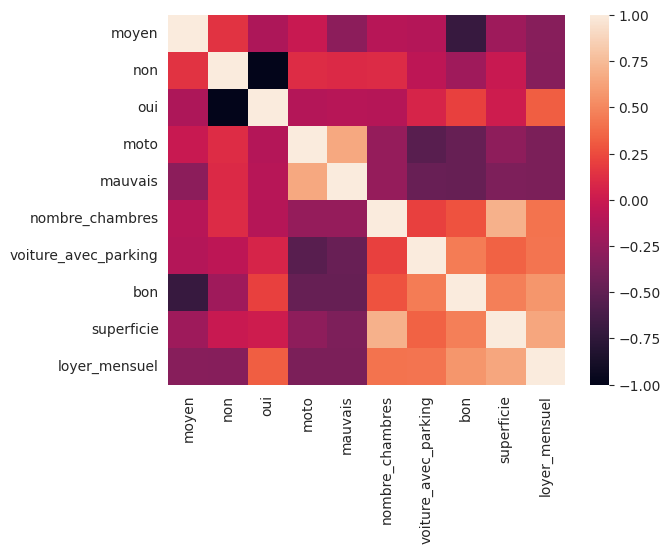

In [215]:
import seaborn as sns
strong_corr = correlation[correlation > 0.3]
corrmat = maison_without_quartier[strong_corr.index].corr()
sns.heatmap(corrmat)

In [227]:
# Normalisation
target = "loyer_mensuel"
features = corrmat.drop([target]).index
maison_normalisation = (maison_without_quartier[features].astype(float) - maison_without_quartier[features].min().astype(float)) / (maison_without_quartier[features].max().astype(float) - maison_without_quartier[features].min().astype(float))

In [232]:
maison_normalisation.var().sort_values()

superficie              0.023550
nombre_chambres         0.030195
oui                     0.045369
non                     0.045369
mauvais                 0.139108
moto                    0.168729
moyen                   0.214473
bon                     0.251219
voiture_avec_parking    0.251594
dtype: float64

In [233]:
# Valeur expliquée
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
y = maison[target]
X = maison_normalisation.iloc[:, maison_normalisation.columns != target]

In [234]:
y

0       300000
1       180000
2       170000
3       250000
4       450000
        ...   
122    1000000
123    1000000
124    1000000
125    1000000
126    1000000
Name: loyer_mensuel, Length: 127, dtype: int64

In [235]:
lr = LinearRegression()
lr.fit(X, y)
train_predictions = lr.predict(X)


In [236]:
train_mse = mean_squared_error(train_predictions, y)

In [237]:
train_rmse = np.sqrt(train_mse)

In [238]:
print(train_rmse)
print(train_mse)

539593.5539256289
291161203438.0906
